In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Simulators import BanditSimulator, ConfoundingBanditSimulator
from Samplers import StandardThomspon, CausalThomspon
from Environment import Environment

In [2]:
def regret_causal(probabilities, choices):
    regret_arr = []
    last = 0
    for i in range(0, len(probabilities)):
        prob = probabilities[i]
        w_opt = prob.max()
        reg = w_opt - prob[choices[i]]
        regret_arr.append(reg + last)
        last = reg + last
    return np.array(regret_arr)

# Probability of Selecting Best Arm
def prob_best_arm_causal(probabilities, choices):
    was_best_selected = [int(np.argmax(prob)==choice) for _,(prob, choice) in enumerate(zip(probabilities, choices))]
    cumulative_best_selected = np.array(was_best_selected).cumsum()
    prob_best = [cumulative_best_selected[i]/(i+1) for i in range(len(cumulative_best_selected))]
    return prob_best

### Standard and Causal Sampler on Confounding Simulator

In [15]:
# Setup the bandit sampler
causal_bandit_probs = np.array([
    np.array([
        np.array([.1, .5]),
        np.array([.4, .2])
    ]),
    np.array([
        np.array([.5, .1]),
        np.array([.2, .4])
    ])
])
confoundingBandits = ConfoundingBanditSimulator(causal_bandit_probs)

# Setup the environment
environment_probs = {
    'drunk': .5,
    'blinking': .5
}
environment = Environment(environment_probs)

# Create our two samplers
standard_sampler = StandardThomspon(confoundingBandits, environment)
causal_sampler = CausalThomspon(confoundingBandits, environment)

In [19]:
def run_simulation(trials, pulls, sampler, true_probabilities):
    exp_total_regret = np.zeros(pulls)
    exp_prob_best_arm = np.zeros(pulls)
    
    for trial in range(trials):
        sampler.initialize()
        sampler.sample_bandits(pulls)
        
        pull_probabilities = [
            true_probabilities[int(env['drunk'])][int(env['blinking'])]
            for env in sampler.observed_envs
        ]
        
        exp_total_regret += regret_causal(pull_probabilities, sampler.choices)
        exp_prob_best_arm += prob_best_arm_causal(pull_probabilities, sampler.choices)
    
    return exp_total_regret, exp_prob_best_arm
        
        

n_pulls = 1000 # number pulls for a trial
n_trials = 10 # number of trials/times we repeat the experiment to get E[regret]

exp_tot_standard_regret, exp_standard_prob_best_arm = run_simulation(
    n_trials, n_pulls, standard_sampler, causal_bandit_probs
)
exp_tot_causal_regret, exp_causal_prob_best_arm = run_simulation(
    n_trials, n_pulls, causal_sampler, causal_bandit_probs
)

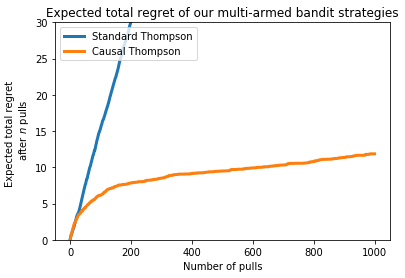

In [20]:
StandardTS_regret_plot = plt.plot(exp_tot_standard_regret/n_trials, lw =3,
                         label = "Standard Thompson")
CausalTS_regret_plot = plt.plot(exp_tot_causal_regret/n_trials, lw =3,
                       label = "Causal Thompson")
plt.ylim(bottom=0,top = 30)
plt.title("Expected total regret of our multi-armed bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()

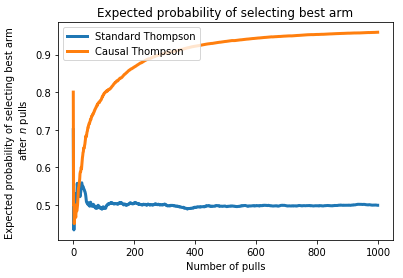

In [21]:
StandardTS_prob_plot = plt.plot(np.divide(exp_standard_prob_best_arm,n_trials), lw =3,
                         label = "Standard Thompson")
CausalTS_prob_plot = plt.plot(np.divide(exp_causal_prob_best_arm,n_trials), lw =3,
                       label = "Causal Thompson")
#plt.ylim(bottom=0,top = 30)
plt.title("Expected probability of selecting best arm")
plt.xlabel("Number of pulls")
plt.ylabel("Expected probability of selecting best arm \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()